<a href="https://colab.research.google.com/github/arlo7777/Project-MIT-Columbia/blob/main/PE_IRR_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error , r2_score , mean_squared_error
from sklearn.metrics import SCORERS
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Input, Dropout
from tensorflow.keras import Model
import tensorflow as tf

In [ ]:
!pip install xgboost
!pip install catboost
!pip install lightgbm
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


open the excel raw data file

In [ ]:
df = pd.read_excel('Data Series Final Draft.xlsx')

we want to see all columns

In [ ]:
df.columns

Index(['Name', 'Asset Class', 'Vintage/Inception Year', 'Strategy',
       'Final Close Size', 'Net IRR %', 'Net Multiple (X)', 'RVPI %',
       'DPI (%)', 'Called %', 'Quartile Rank', 'Date Reported', 'Status',
       'Geographic Focus', 'Fund Manager', 'Country', 'Core Industries',
       'Industry Verticals', 'Fund Number (Overall)', 'Fund Number (Series)',
       'Industries', 'Date 10-yr Treasury', '10-yr Treasury (Adj Close)',
       'Date MSCI', 'MSCI (Adj Close)'],
      dtype='object')

make a new list of 4 variables that we need to interpolate, then we drop them from our data set

In [ ]:
date_df = df[['Date 10-yr Treasury', '10-yr Treasury (Adj Close)', 'Date MSCI', 'MSCI (Adj Close)']]
df  = df.drop(columns=['Date 10-yr Treasury', '10-yr Treasury (Adj Close)', 'Date MSCI', 'MSCI (Adj Close)'])

convert between date formats

In [ ]:
date_df['Treasury_year'] = pd.to_datetime(date_df['Date 10-yr Treasury']).dt.year
date_df['MSCI_year'] = pd.to_datetime(date_df['Date MSCI']).dt.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


interpolate monthly to yearly using the yearly mean

In [ ]:
treasury_per_year = date_df.groupby(['Treasury_year']).agg({'10-yr Treasury (Adj Close)':'mean'}).reset_index()
msci_per_year = date_df.groupby(['MSCI_year']).agg({'MSCI (Adj Close)':'mean'}).reset_index()
msci_per_year 
treasury_per_year

,Treasury_year,10-yr Treasury (Adj Close)
0,1985.0,10.535833
1,1986.0,7.570000
2,1987.0,8.412500
3,1988.0,8.830833
4,1989.0,8.452500
5,1990.0,8.557500
6,1991.0,7.789167
7,1992.0,7.030000
8,1993.0,5.842167
9,1994.0,7.120417


merge or 'groupby' Vintage Year, this means match the data for any given year to the Vintage year and put it in the same row

In [ ]:
df = pd.merge(df,msci_per_year, left_on='Vintage/Inception Year', right_on='MSCI_year', how='left' )

df = pd.merge(df,treasury_per_year, left_on='Vintage/Inception Year', right_on='Treasury_year', how='left' )

create a correlation matrix

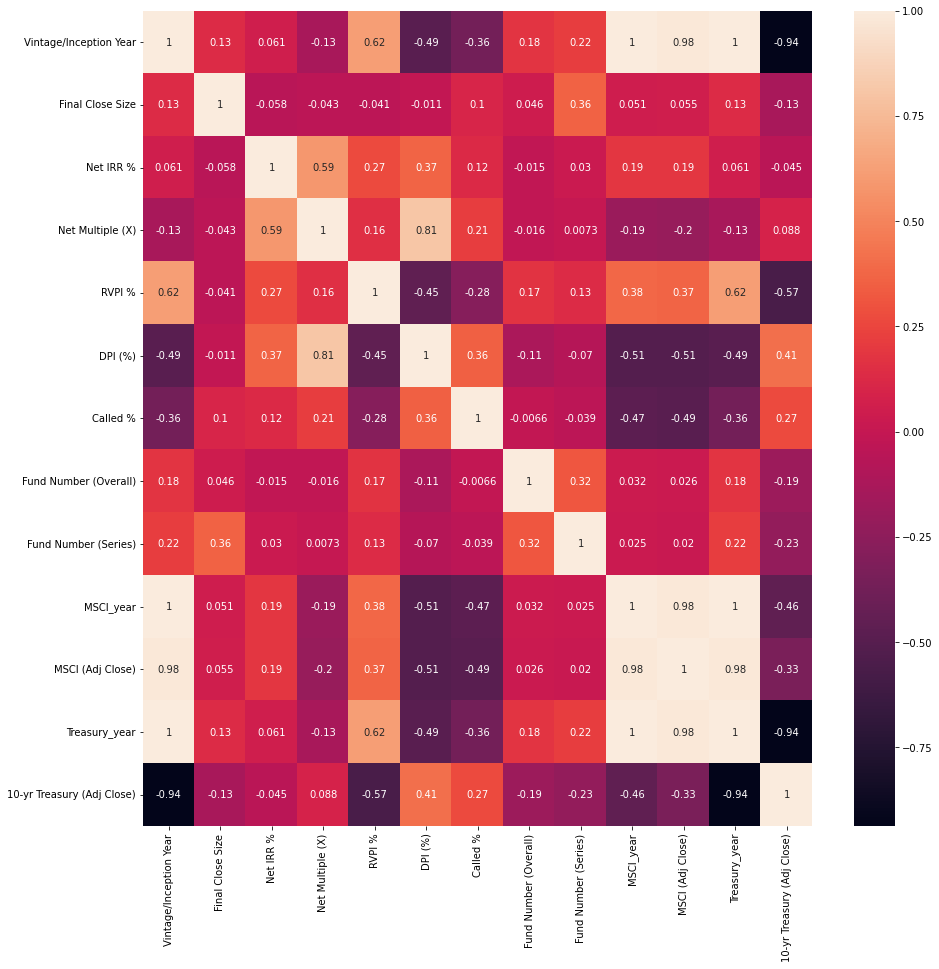

In [ ]:
sns.heatmap(df.corr(), annot=True)

take the absolute value of the correlation coefficient 

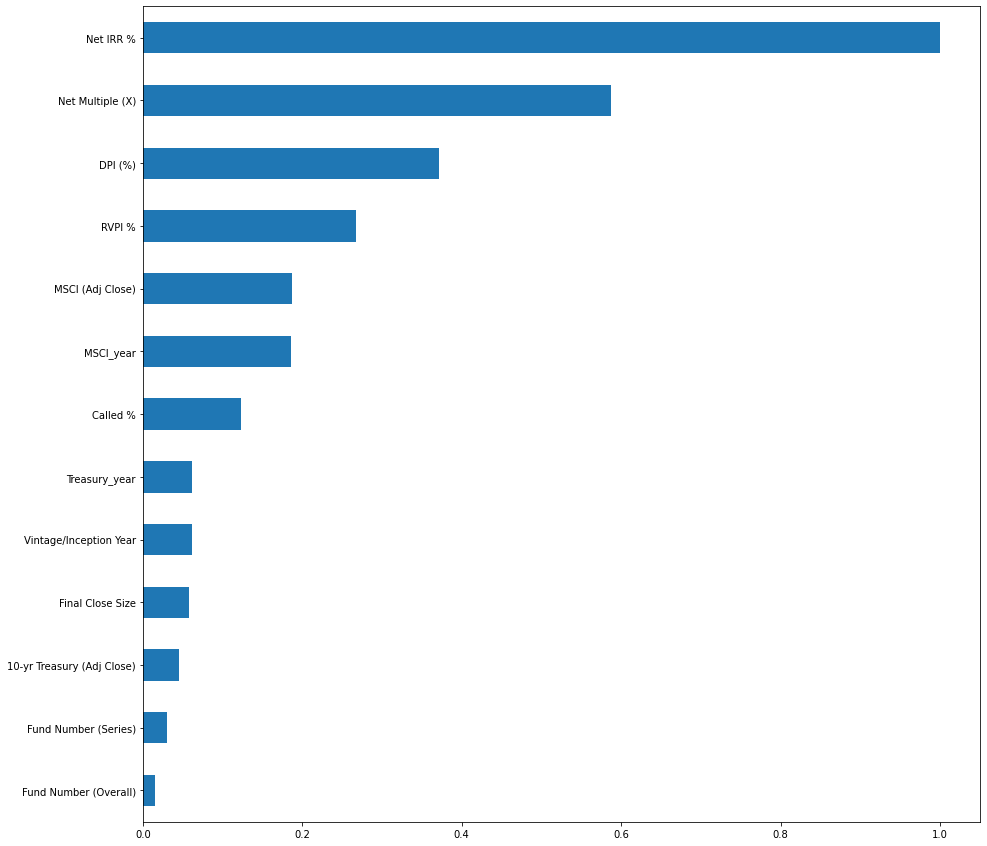

In [ ]:
abs(df.corr()['Net IRR %']).sort_values().plot.barh()

examine summary stats

In [ ]:
summary_stats  = df.describe(include='all')
summary_stats

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,Name,Asset Class,Vintage/Inception Year,Strategy,Final Close Size,Net IRR %,Net Multiple (X),RVPI %,DPI (%),Called %,...,Country,Core Industries,Industry Verticals,Fund Number (Overall),Fund Number (Series),Industries,MSCI_year,MSCI (Adj Close),Treasury_year,10-yr Treasury (Adj Close)
count,907,907,907.000000,907,901.000000,789.000000,844.000000,855.000000,859.000000,879.000000,...,907,907,907,907.000000,901.000000,897,441.000000,441.000000,907.000000,907.000000
unique,907,1,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,...,46,16,57,NaN,NaN,653,NaN,NaN,NaN,NaN
top,Agilitas 2020 Private Equity Fund SCSp,Private Equity,NaN,Buyout,NaN,NaN,NaN,NaN,NaN,NaN,...,US,Diversified,Manufacturing,NaN,NaN,"Consumer Services, Logistics & Distribution",NaN,NaN,NaN,NaN
freq,1,907,NaN,585,NaN,NaN,NaN,NaN,NaN,NaN,...,520,613,585,NaN,NaN,29,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2008.080485,NaN,297.529223,16.697698,1.813024,55.983138,124.796456,88.640238,...,NaN,NaN,NaN,3.545755,2.499445,NaN,2014.240363,31.790398,2008.080485,3.769547
std,NaN,NaN,7.368653,NaN,242.962537,21.614580,1.042220,68.603600,114.944185,23.735285,...,NaN,NaN,NaN,5.108627,1.670412,NaN,3.210962,11.871120,7.368653,1.591439
min,NaN,NaN,1985.000000,NaN,5.400000,-100.000000,0.000000,0.000000,0.000000,0.614286,...,NaN,NaN,NaN,1.000000,1.000000,NaN,2009.000000,17.906046,1985.000000,0.816250
25%,NaN,NaN,2004.000000,NaN,107.000000,6.900000,1.179347,0.000000,32.335044,81.728291,...,NaN,NaN,NaN,1.000000,1.000000,NaN,2011.000000,19.073668,2004.000000,2.359000


analyze the data type to determine interpolation method

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 907 entries, 0 to 906
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Name                        907 non-null    object        
 1   Asset Class                 907 non-null    object        
 2   Vintage/Inception Year      907 non-null    int64         
 3   Strategy                    907 non-null    object        
 4   Final Close Size            901 non-null    float64       
 5   Net IRR %                   789 non-null    float64       
 6   Net Multiple (X)            844 non-null    float64       
 7   RVPI %                      855 non-null    float64       
 8   DPI (%)                     859 non-null    float64       
 9   Called %                    879 non-null    float64       
 10  Quartile Rank               598 non-null    object        
 11  Date Reported               907 non-null    datetime64[ns]

show the first 5 rows

In [ ]:
df.head()

,Name,Asset Class,Vintage/Inception Year,Strategy,Final Close Size,Net IRR %,Net Multiple (X),RVPI %,DPI (%),Called %,...,Country,Core Industries,Industry Verticals,Fund Number (Overall),Fund Number (Series),Industries,MSCI_year,MSCI (Adj Close),Treasury_year,10-yr Treasury (Adj Close)
0,Agilitas 2020 Private Equity Fund SCSp,Private Equity,2021,Buyout,673.12,NaN,0.000000,0.000000,0.0,1.648913,...,UK,Diversified,Infrastructure,4,NaN,"Education/Training, Environmental Services, He...",2021.0,66.195776,2021.0,1.46150
1,SSC Partners II,Private Equity,2020,Buyout,555.00,NaN,0.847797,84.779688,0.0,6.936520,...,US,Diversified,Manufacturing,3,2.0,"Aerospace, Chemicals, Environmental Services, ...",2020.0,53.608141,2020.0,0.81625
2,Aldea Tech Fund I,Private Equity,2020,Fund of Funds,98.98,NaN,1.180000,118.000000,0.0,56.000000,...,Spain,Diversified,"Artificial Intelligence, Cloud Computing, Heal...",1,1.0,"Diversified, Information Technology",2020.0,53.608141,2020.0,0.81625
3,Polaris V,Private Equity,2020,Buyout,744.41,NaN,0.810000,81.000000,0.0,20.220000,...,Denmark,Diversified,"Clean Technology, Manufacturing",5,5.0,"Diversified, Business Support Services, Chemic...",2020.0,53.608141,2020.0,0.81625
4,iXO 4,Private Equity,2019,Buyout,228.14,-40.529116,0.795500,79.550000,0.0,20.450000,...,France,Diversified,Manufacturing,5,4.0,"Diversified, Biotechnology, Consumer Products,...",2019.0,49.988119,2019.0,2.08325


see how many missing values in each column - this is important to decide what rows to drop and how to interpolate missing values

In [ ]:
df.isnull().sum()

Name                            0
Asset Class                     0
Vintage/Inception Year          0
Strategy                        0
Final Close Size                6
Net IRR %                     118
Net Multiple (X)               63
RVPI %                         52
DPI (%)                        48
Called %                       28
Quartile Rank                 309
Date Reported                   0
Status                          0
Geographic Focus                4
Fund Manager                    0
Country                         0
Core Industries                 0
Industry Verticals              0
Fund Number (Overall)           0
Fund Number (Series)            6
Industries                     10
MSCI_year                     466
MSCI (Adj Close)              466
Treasury_year                   0
10-yr Treasury (Adj Close)      0
dtype: int64

create a list of columns to drop

In [ ]:
drop_cols = ["Name", "Asset Class", "Quartile Rank", "Date Reported", "Status", "Geographic Focus", "Fund Manager", "Industry Verticals", "Industries"]

drop these columns as they are not inputs of the prediction model, then look at the first 5 *rows*

In [ ]:
data = df.drop(drop_cols,axis = 1)
data.head()

,Vintage/Inception Year,Strategy,Final Close Size,Net IRR %,Net Multiple (X),RVPI %,DPI (%),Called %,Country,Core Industries,Fund Number (Overall),Fund Number (Series),MSCI_year,MSCI (Adj Close),Treasury_year,10-yr Treasury (Adj Close)
0,2021,Buyout,673.12,NaN,0.000000,0.000000,0.0,1.648913,UK,Diversified,4,NaN,2021.0,66.195776,2021.0,1.46150
1,2020,Buyout,555.00,NaN,0.847797,84.779688,0.0,6.936520,US,Diversified,3,2.0,2020.0,53.608141,2020.0,0.81625
2,2020,Fund of Funds,98.98,NaN,1.180000,118.000000,0.0,56.000000,Spain,Diversified,1,1.0,2020.0,53.608141,2020.0,0.81625
3,2020,Buyout,744.41,NaN,0.810000,81.000000,0.0,20.220000,Denmark,Diversified,5,5.0,2020.0,53.608141,2020.0,0.81625
4,2019,Buyout,228.14,-40.529116,0.795500,79.550000,0.0,20.450000,France,Diversified,5,4.0,2019.0,49.988119,2019.0,2.08325


create a list of numerical columns, and remove IRR as it's our target variable

In [ ]:
numerical_columns = [i for i in data.columns if data[i].dtype not in ('datetime64[ns]', 'object')]
numerical_columns.remove('Net IRR %')

create a list of categorical columns, then drop Asset Class column

In [ ]:
categorical_columns = list(summary_stats.loc['unique'].index[list(summary_stats.loc['unique'].values < 17)])
categorical_columns.remove('Asset Class')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [ ]:
drop_columns = drop_cols

create boxplot chart

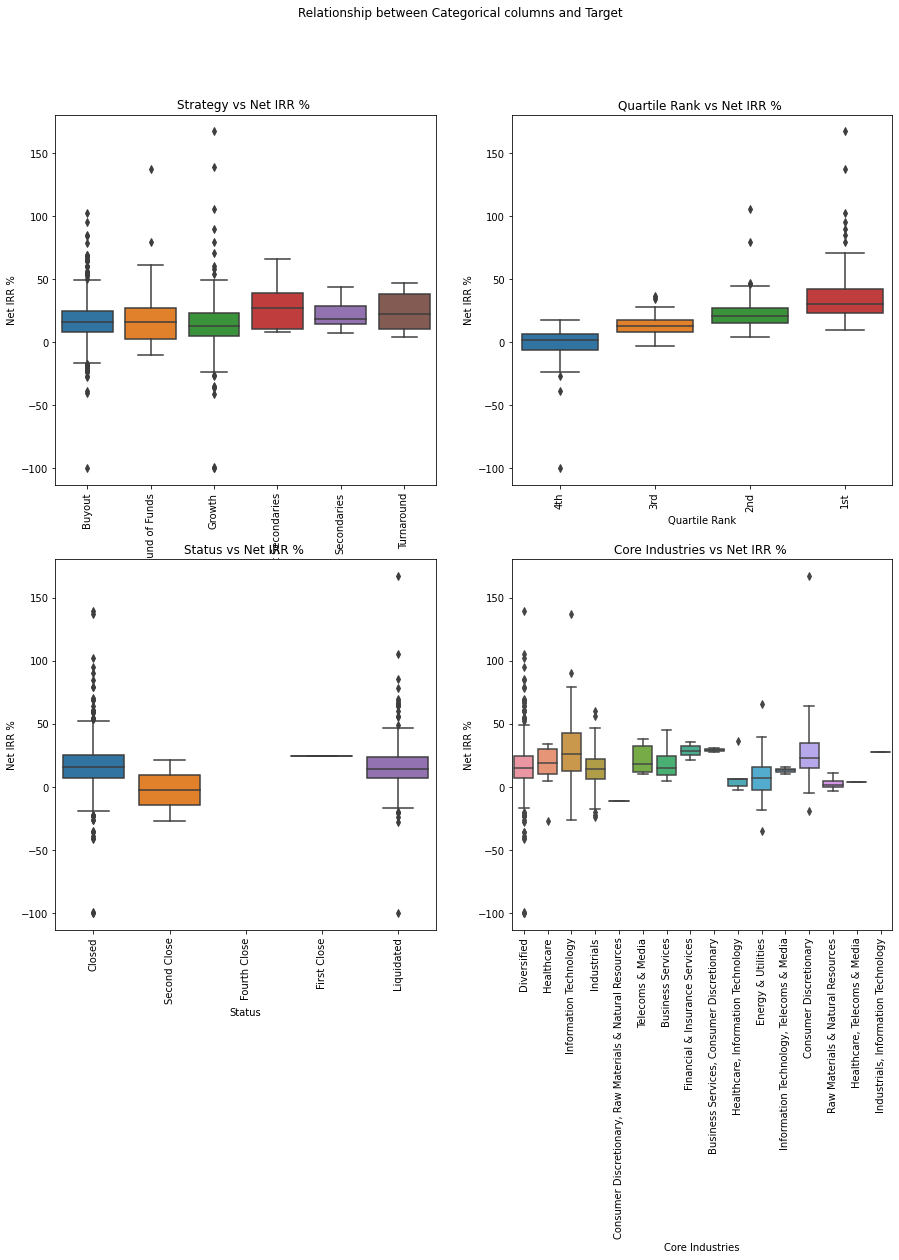

In [ ]:
fig, axes = plt.subplots(2, 2)
fig.suptitle('Relationship between Categorical columns and Target')
for x, y in enumerate(categorical_columns):
  sns.boxplot(ax=axes[x//2, x%2], x=y, y='Net IRR %', data=df)
  axes[x//2, x%2].set_title(f'{y} vs Net IRR % ')
  axes[x//2, x%2].tick_params(axis='x', rotation=90)

interpolate missing numerical values using mean

In [ ]:
def fillna_numeric(df, columns):
    for i in columns:
        df[i] = df[i].fillna(df[~df[i].isnull()][i].mean())
    return df

drop rows with missing IRR values

In [ ]:
df = df[~df['Net IRR %'].isna()]

drop these columns as they are not inputs of the prediction model, then look at the first 5 *rows*

In [ ]:
data = df.drop(drop_cols,axis = 1)
data.head()

,Vintage/Inception Year,Strategy,Final Close Size,Net IRR %,Net Multiple (X),RVPI %,DPI (%),Called %,Country,Core Industries,Fund Number (Overall),Fund Number (Series),MSCI_year,MSCI (Adj Close),Treasury_year,10-yr Treasury (Adj Close)
4,2019,Buyout,228.14,-40.529116,0.795500,79.550000,0.00,20.450000,France,Diversified,5,4.0,2019.0,49.988119,2019.0,2.08325
5,2019,Growth,NaN,-26.640000,0.809908,80.990800,0.00,13.500000,US,Healthcare,9,1.0,2019.0,49.988119,2019.0,2.08325
6,2019,Growth,55.22,-26.400000,0.771300,76.650000,0.48,29.830000,Japan,Information Technology,10,1.0,2019.0,49.988119,2019.0,2.08325
7,2019,Buyout,940.00,-22.480000,0.880669,88.066949,0.00,35.067783,US,Industrials,4,4.0,2019.0,49.988119,2019.0,2.08325
8,2019,Buyout,710.40,-22.210000,0.773200,77.320000,0.00,51.650000,Canada,Diversified,8,5.0,2019.0,49.988119,2019.0,2.08325


create X=features, exclude IRR; Y=target = IRR

In [ ]:
X = data.drop('Net IRR %' , axis = 1)
y = data['Net IRR %']

Analyze the data

In [ ]:
X.isnull().sum()

Vintage/Inception Year          0
Strategy                        0
Final Close Size                3
Net Multiple (X)               63
RVPI %                         52
DPI (%)                        48
Called %                       28
Country                         0
Core Industries                 0
Fund Number (Overall)           0
Fund Number (Series)            4
MSCI_year                     405
MSCI (Adj Close)              405
Treasury_year                   0
10-yr Treasury (Adj Close)      0
dtype: int64

Analyze data types

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 789 entries, 4 to 906
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Vintage/Inception Year      789 non-null    int64  
 1   Strategy                    789 non-null    object 
 2   Final Close Size            786 non-null    float64
 3   Net Multiple (X)            726 non-null    float64
 4   RVPI %                      737 non-null    float64
 5   DPI (%)                     741 non-null    float64
 6   Called %                    761 non-null    float64
 7   Country                     789 non-null    object 
 8   Core Industries             789 non-null    object 
 9   Fund Number (Overall)       789 non-null    int64  
 10  Fund Number (Series)        785 non-null    float64
 11  MSCI_year                   384 non-null    float64
 12  MSCI (Adj Close)            384 non-null    float64
 13  Treasury_year               789 non

analyze unique values in catgorical columns

In [ ]:
cat_cols = X.select_dtypes('object').columns
for col in cat_cols:
    print(col , ' ' ,X[col].unique())

Strategy   ['Buyout' 'Growth' 'Fund of Funds' 'Direct Secondaries' 'Secondaries'
 'Turnaround']
Country   ['France' 'US' 'Japan' 'Canada' 'UK' 'Portugal' 'Ireland' 'Luxembourg'
 'China' 'Lithuania' 'Germany' 'Brazil' 'Czech Republic'
 'Hong Kong SAR - China' 'Mexico' 'Malaysia' 'Italy' 'Netherlands'
 'Poland' 'Mauritius' 'Sweden' 'Russia' 'Denmark' 'Ukraine' 'India'
 'Switzerland' 'South Korea' 'Hungary' 'Vietnam' 'Singapore' 'Barbados'
 'Israel' 'Colombia' 'Peru' 'Finland' 'Romania' 'United Arab Emirates'
 'Turkey' 'Norway' 'Kazakhstan' 'Spain' 'Greece' 'Jersey' 'Austria']
Core Industries   ['Diversified' 'Healthcare' 'Information Technology' 'Industrials'
 'Consumer Discretionary, Raw Materials & Natural Resources'
 'Telecoms & Media' 'Business Services' 'Financial & Insurance Services'
 'Business Services, Consumer Discretionary'
 'Healthcare, Information Technology' 'Energy & Utilities'
 'Information Technology, Telecoms & Media' 'Consumer Discretionary'
 'Raw Materials & Natural R

This is a one-hot-encoding function. In this case, we use it for all models. 

I mentioned earlier that LGBM can take categorical values which makes it faster, but it can also take a matrix of ones and zeros. We use one-hot-encoding for all models, meaning that all models train on the same data. 

X train and X test comes from X

In [ ]:
X = pd.get_dummies(X , columns=cat_cols, drop_first = True)

Do a 20/80 split. Train on 80% of data, test on 20%. 

This is what we did to normalize the results and make it possible to have more consistent results every time we run the code. 

So what random_state does is fixes train and test data every time we run the code, so results are more consistent. However, they will still vary because the models will have their own training that they will apply on the data sets.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2 , random_state = 42 , shuffle=True)
X_train.shape , y_train.shape , X_test.shape , y_test.shape

((631, 75), (631,), (158, 75), (158,))

Examine the data

In [ ]:
X_train.head()

,Vintage/Inception Year,Final Close Size,Net Multiple (X),RVPI %,DPI (%),Called %,Fund Number (Overall),Fund Number (Series),MSCI_year,MSCI (Adj Close),...,Core Industries_Financial & Insurance Services,Core Industries_Healthcare,"Core Industries_Healthcare, Information Technology","Core Industries_Healthcare, Telecoms & Media",Core Industries_Industrials,"Core Industries_Industrials, Information Technology",Core Industries_Information Technology,"Core Industries_Information Technology, Telecoms & Media",Core Industries_Raw Materials & Natural Resources,Core Industries_Telecoms & Media
237,2014,202.00,3.734400,300.440000,73.000000,78.500000,5,5.0,2014.0,30.215100,...,0,1,0,0,0,0,0,0,0,0
153,2016,445.00,2.117600,126.350000,85.410000,100.479990,8,3.0,2016.0,36.716827,...,0,0,0,0,0,0,0,0,0,0
858,1995,105.20,1.948878,24.418936,170.468813,98.421128,2,2.0,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
624,2005,662.40,1.578500,0.000000,157.850000,91.480000,6,7.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
63,2018,281.38,1.668600,112.950000,53.910000,69.960000,3,3.0,2018.0,46.604786,...,0,0,0,0,0,0,0,0,0,0


Examine the dimansions, making sure they are consistent with what actions we are applying. (row, col)

In [ ]:
X_train.shape, X_test.shape

((631, 75), (158, 75))

Pandas interpolate function is a great and most popular way to interpolate in data science. 

It replaces missing values according to different methods.

In [ ]:
X_train = X_train.interpolate()
X_test = X_test.interpolate()

Check for null values.

X_train has no null values, X_test has 2 null cells. 

In [ ]:
X_train.isnull().sum().sum(), X_test.isnull().sum().sum()

(0, 2)

Fill missing X_test cells with a median value. 

In [ ]:
X_train.dropna(inplace = True)
X_test.fillna(X_test.median(),inplace = True)

Check for missing values again... Done with data cleaning!

Ready to implement the models! :-)

In [ ]:
X_train.isnull().sum().sum() , X_test.isnull().sum().sum()

(0, 0)

XGBoost

This is an evaluate function which simply calculates the mentioned statistics.

In [ ]:
def evaluate(actual,pred):
    mse = mean_absolute_error(actual , pred)
    rsq = r2_score(actual , pred)
    return [mse , rsq]

xgb = is the XGBoost regressor, and we are not using any parameters in this case. 

Instead we are using the default mode, and let the model decide what is best for this dataset. 

In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
evaluate(y_test,xgb.predict(X_test))

[18:19:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[9.969418709695336, 0.27652229361272684]

Make an IRR prediction using X_test as input.

In [ ]:
xgb_y_pred = xgb.predict(X_test)

In [ ]:
xgb_ = xgb.predict(X_train)
mean_absolute_error(xgb_, y_train)

#xgb_metric = mean_absolute_error(xgb_y_pred, y_test)
xgb_metrics_squared = mean_squared_error(xgb_y_pred, y_test) ** 0.5

xgb_metric, xgb_r2_score = evaluate(y_test, xgb_y_pred)

print(xgb_metric, xgb_r2_score)



9.969418709695336 0.27652229361272684


LGBM

Here, a lower learning rate should find a better optimum than a higher learning rate. Additionally, one way to improve the performance is to still tune the hyper-parameters using grid search to find the best combination of learning rate along with the other hyper-parameters. 

In our case we thought a learning rate of .09 is reasonable. 

In [ ]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(learning_rate=0.09)
lgb_model.fit(X_train.values, y_train)

lgb_preds = lgb_model.predict(X_test.values)

lgb_metrics_squared = mean_squared_error(lgb_preds, y_test) ** 0.5
lgb_metric, lgb_r2_score = evaluate(y_test, lgb_preds)

print(lgb_metric, lgb_r2_score)

10.744443422966127 0.2592881642606143


Catboost

In [ ]:
from catboost import CatBoostRegressor
# Initialize data

cat_model = CatBoostRegressor(iterations=2,
                          learning_rate=1,
                          depth=2)
# Fit model
cat_model.fit(X_train, y_train)
# Get predictions
cat_preds = cat_model.predict(X_test)

0:	learn: 17.0294013	total: 47.3ms	remaining: 47.3ms
1:	learn: 15.9893028	total: 50ms	remaining: 0us


In [ ]:
cat_metrics_squared = mean_squared_error(cat_preds, y_test) ** 0.5

cat_metric, cat_r2_score = evaluate(y_test, cat_preds)
print(cat_metric, cat_r2_score)

11.837040437747781 0.2242797850978513


Neural Network

Here we set patience=100, which means that the training will terminate after 100 interations if there is no improvement in the performance. 

In [ ]:
cp_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=100, restore_best_weights=True)

Here we have a connected layer of 128 neurons, and an activation function 'relu'. 

One thing we do to avoid overfitting here is this : x = Dropout(0.8)(x) --> this means that we keep only 80% of the data and ignore 20%. 

We leveraged Tensoflow, but this can also be done using Keras library. 

"TensorFlow is an open-sourced end-to-end platform, a library for multiple machine learning tasks, while Keras is a high-level neural network library that runs on top of TensorFlow."


In [ ]:
input = Input(shape=(X_test.shape[1],))
x = BatchNormalization()(input) #scaling of data, normalize from -1 to 1
# x = Dense(128, activation='tanh')(x)
# x = Dense(128, activation='tanh')(x) 
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.8)(x)   

x = BatchNormalization()(x)     #more layers
x = Dense(128, activation='relu')(x)
# x = Dense(128, activation='relu')(x)
x = Dense(128)(x)
x = Dropout(0.8)(x)

x = BatchNormalization()(x)
x = Dense(128)(x)
x = Dense(128)(x)
# x = Dense(128)(x)

#-----tensorflow
output = Dense(1, activation='relu')(x) #one IRR value per row output
nn_model = Model(input, output). #keras deep learning library
nn_model.compile(metrics='mae', loss ='mae', optimizer ='rmsprop' )
#-----

nn_model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs= 1000, callbacks=cp_callback)

Epoch 1/1000
20/20 [==============================] - 3s 29ms/step - loss: 17.7846 - mae: 17.7846 - val_loss: 159.4848 - val_mae: 159.4848
Epoch 2/1000
20/20 [==============================] - 0s 5ms/step - loss: 16.1859 - mae: 16.1859 - val_loss: 224.2166 - val_mae: 224.2166
Epoch 3/1000
20/20 [==============================] - 0s 9ms/step - loss: 15.9138 - mae: 15.9138 - val_loss: 154.8108 - val_mae: 154.8108
Epoch 4/1000
20/20 [==============================] - 0s 7ms/step - loss: 15.1295 - mae: 15.1295 - val_loss: 95.4121 - val_mae: 95.4121
Epoch 5/1000
20/20 [==============================] - 0s 5ms/step - loss: 14.8184 - mae: 14.8184 - val_loss: 23.1023 - val_mae: 23.1023
Epoch 6/1000
20/20 [==============================] - 0s 11ms/step - loss: 14.2100 - mae: 14.2100 - val_loss: 14.1555 - val_mae: 14.1555
Epoch 7/1000
20/20 [==============================] - 0s 6ms/step - loss: 13.4847 - mae: 13.4847 - val_loss: 33.8346 - val_mae: 33.8346
Epoch 8/1000
20/20 [====================

Here we make the prediction.

In [ ]:
neural_ntwrk_r2 =r2_score(y_test, nn_model.predict(X_test))
neural_ntwrk_r2

5/5 [==============================] - 0s 2ms/step


0.28514722020063443

Calculate stats

In [ ]:
neural_ntwrk = mean_absolute_error(y_test, nn_model.predict(X_test))
neural_ntwrk

5/5 [==============================] - 0s 2ms/step


11.243083990399596

more stats

In [ ]:
neural_ntwrk_squared = np.sqrt(mean_squared_error(y_test, nn_model.predict(X_test)))

5/5 [==============================] - 0s 2ms/step


Final KPI metrics

In [ ]:
model_metrics = {'XGB': xgb_metric,'neural_ntwrk': neural_ntwrk, 'CAT': cat_metric, 'LIGHTGBM': lgb_metric}
model_metrics_rmse = {'XGB': xgb_metrics_squared, 'neural_ntwrk': neural_ntwrk_squared ,'CAT': cat_metrics_squared, 'LIGHTGBM': lgb_metrics_squared}
model_metrics_r2 = {'XGB': xgb_r2_score, 'CAT': cat_r2_score, 'neural_ntwrk':neural_ntwrk_r2, 'LIGHTGBM': lgb_r2_score}

MAE (Mean Absolute Error)

To be detrmined live, as the results will slightly vary each time the models are run. 

Text(0, 0.5, 'MAE')

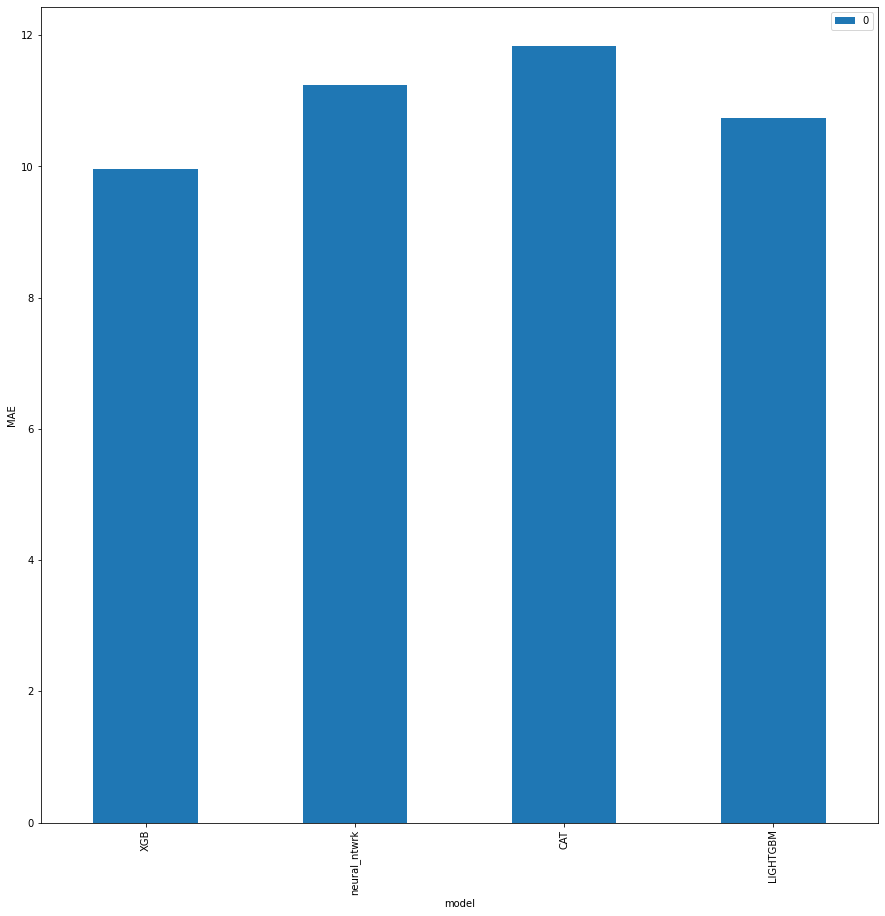

In [ ]:
ax = pd.DataFrame(model_metrics.values(), model_metrics.keys()).plot.bar()
ax.set_xlabel("model")
ax.set_ylabel("MAE")

RSME (Root Mean Square Error)

To be detrmined live, as the results will slightly vary each time the models are run. 

Text(0, 0.5, 'RMSE')

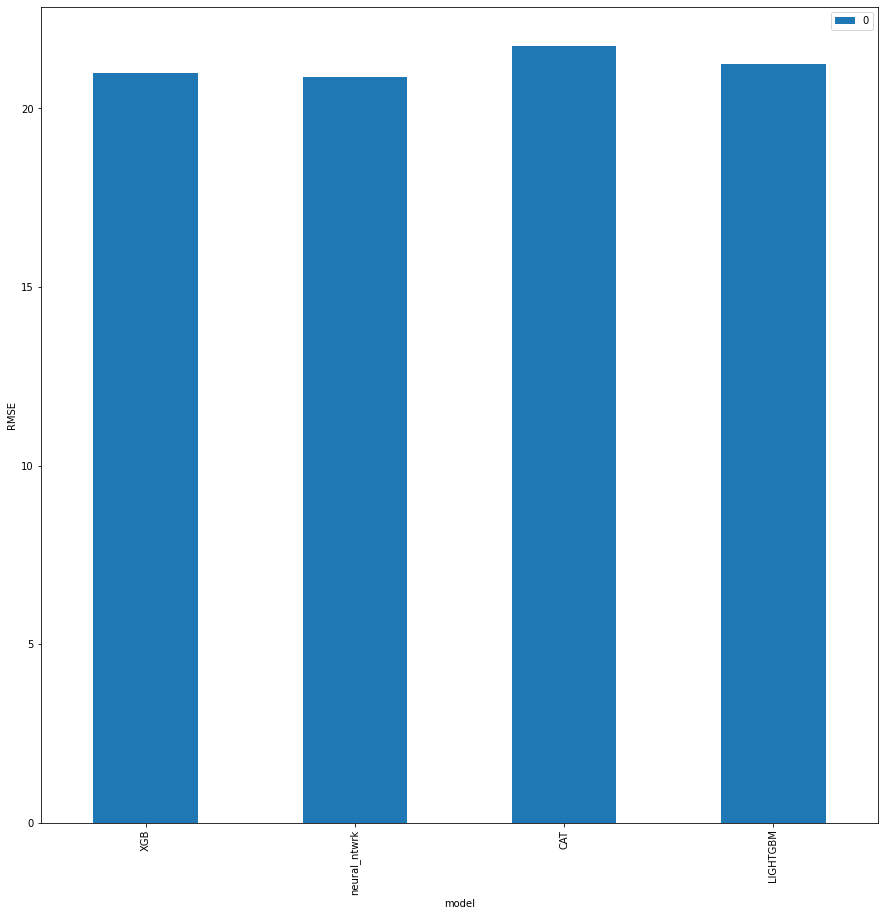

In [ ]:
ax = pd.DataFrame(model_metrics_rmse.values(), model_metrics_rmse.keys()).plot.bar()
ax.set_xlabel("model")
ax.set_ylabel("RMSE")

R-Squared

To be detrmined live, as the results will slightly vary each time the models are run. 

Text(0, 0.5, 'R_Squared')

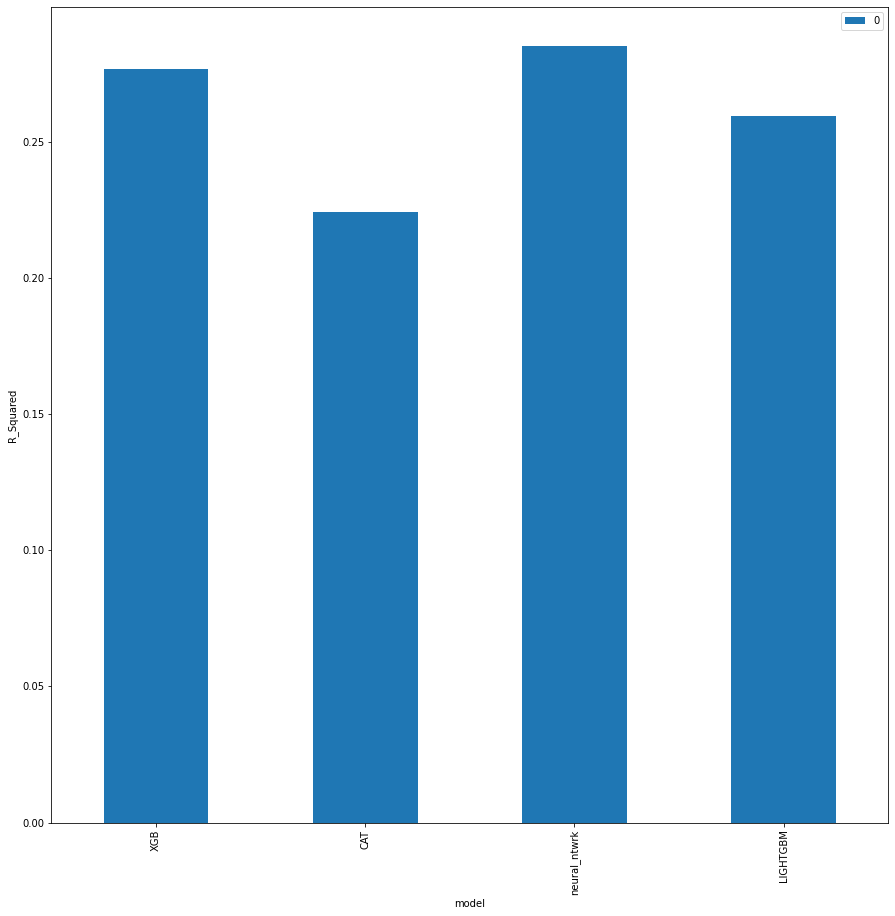

In [ ]:
ax = pd.DataFrame(model_metrics_r2.values(), model_metrics_r2.keys()).plot.bar()
ax.set_xlabel("model")
ax.set_ylabel("R_Squared")

Another way to think about the prediction vs actual result. 

5/5 [==============================] - 0s 3ms/step


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


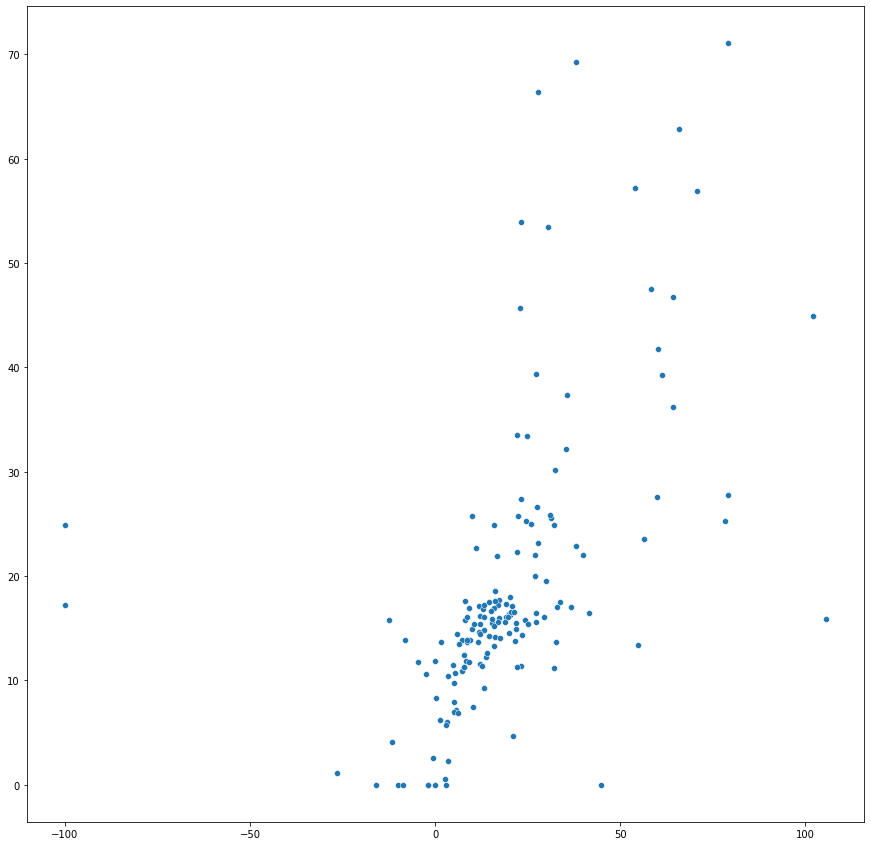

In [ ]:
sns.scatterplot(np.array(y_test), nn_model.predict(X_test)[:, 0])

**Thank you!**

https://tenor.com/view/cheer-smile-thumbs-up-good-job-gif-14538653

---



Arlo 